In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import random
import scipy.stats as stt
import heapq

# Functions

In [2]:
def largest_n_elements(lst, n):
    if len(lst)>=n:
        lst2 = heapq.nlargest(n, lst)
    else:
        lst2 = lst
    return lst2

In [3]:
import pickle

#with open("test.txt", "wb") as fp:   #Pickling
#    pickle.dump(var, fp)

#with open("test.txt", "rb") as fp:   # Unpickling
#    var2 = pickle.load(fp)

In [4]:
def linear_regression(sol):
    y = []
    x = []
    for i in range(0, N_eras):
        for j in range(0, N_rep):
            x.append(i)
            y.append(sol[j][i])

    LL = int(len(x)/2)
    slope, intercept = np.polyfit(x[LL:-1], y[LL:-1], 1)
    return slope, intercept

In [5]:
def unpack_solution(sol):
    n_rep = len(sol)
    initiatives = len(sol[0])
    groups = len(sol[0][0])
    
    final_values = [[] for j in range(0, groups)]
    for g in range(0, groups):
        kol = [[] for j in range(0, initiatives)]
        for i in range(0, initiatives):
            for rep in range(0, n_rep):
                val = sol[rep][i][g]
                #print(i, initiatives, kol)
                kol[i].append(val)
                
        x = range(0, len(kol))
        m = [np.mean(el) for el in kol]
        s = [np.std(el) for el in kol]
        final_values[g] = [np.array(x), np.array(m), np.array(s)]
        
    return final_values

In [6]:
def get_inequality(sol):
    n_rep = len(sol)
    initiatives = len(sol[0])
    groups = len(sol[0][0])
    
    kol_vec = []
    for g in range(0, groups):
        kol = [[] for j in range(0, initiatives)]
        for i in range(0, initiatives):
            for rep in range(0, n_rep):
                val = sol[rep][i][g]
                #print(i, initiatives, kol)
                kol[i].append(val)
        kol2 = np.array([np.array(el) for el in kol])
        kol_vec.append(kol2)
        
    ineq = (kol_vec[0]-kol_vec[-1])/(kol_vec[0]+kol_vec[-1])
    
    ix_ = range(0, len(ineq))
    im_ = [np.mean(el) for el in ineq]
    is_ = [np.std(el) for el in ineq]
    
    return np.array(ix_), np.array(im_), np.array(is_)

# Load?

In [7]:
LOAD = False

In [ ]:
if LOAD:
    with open("AllData_v2.txt", "rb") as fp:   # Unpickling
        save_var = pickle.load(fp)
        
    solutions_m1, solutions_m2, solutions_m3, solutions_m4, solutions_m2a, solutions_m4a, solutions_m1, solutions_m4_noise, solutions_m4_noise_groups, solutions_m4_noise_groups_g1 = save_var

# Test general algorithm

In [8]:
n_rep = 10

n_initiatives = 30

# Parameters
groups_population = [990, 10]
n_steps = 1000
dimensions = 10
delta = 3 # How many dimensions are take into account


# Functions
random_func = lambda n, MAX : 0.001*np.clip((1/np.random.rand(n)), a_min=-100, a_max=MAX) # 1/x with lower variance
ineq_funct = lambda v : (v[0]-v[1])/(v[0]+v[1])

# Additional boolean parameters
SEPARATE_POOLS = True # If True each group will have their own pool
WHAT_TO_LOAD = "nothing" # "all", final", "nothing"

# Noise parameters
noise_val = 0.
noise_fun = lambda n : (np.random.rand(n)-0.5)*2*noise_val





solutionx = []
for i in range(0, n_rep):

    n_populations = len(groups_population)

    ## VARIABLES OF THE KB
    # The kb will keep track on how many designs are per each population and per each 
    kb_l = [[0]*dimensions for i in range(0, n_populations)]
    kb_l_shared = [0]*dimensions
    kb_s = [[0]*dimensions for i in range(0, n_populations)]
    max_kbs = [[0]*dimensions for i in range(0, n_populations)] # the max design value for each dimension
    dims_each_group = [[0]*delta for i in range(0, n_populations)]


    #
    winning_solution_vec = []
    
    for initiative in range(0,n_initiatives) :# for each initiative #######################
        max_kbs = [[0]*dimensions for i in range(0, n_populations)] # set this to 0
        kb_s = [[0]*dimensions for i in range(0, n_populations)]

        # Load the short term kb
        for group, li in enumerate(kb_l):

            # Load the knowledge bases
            if SEPARATE_POOLS:
                kb_s[group] = li.copy()
            else:
                kb_s[group] = kb_l_shared.copy()

            # Select which dimensions everyone is going to work on
            dims_each_group[group] = random.sample(range(0,dimensions), k=delta)
            
            for dim in dims_each_group[group]:
                L = kb_s[group][dim]
                if L > 0:
                    max_kbs[group][dim] = np.max(random_func(L, L))
        


        # Simulate the actions during the initiative
        for h in range(0, n_steps):

            # select group of the agent
            group = random.choices(range(0, n_populations), weights=groups_population, k=1)[0]

            # Select a random dimension
            dim = random.choices(dims_each_group[group], k=1)[0]

            # How many solutions have been already generated and what is the maximum
            L = kb_s[group][dim]
            M = max_kbs[group][dim]

            # Generate a new solution
            sol = random_func(1, L)[0]
            kb_s[group][dim] += 1

            if sol > M:
                max_kbs[group][dim] = sol


        # End of initiative actions
        # Select the winning solutions for each one
        winning_solution = []
        for group in range(0, n_populations):
            sol = 0 

            for dim in dims_each_group[group]:
                sol += max_kbs[group][dim]
                err = np.mean(noise_fun(groups_population[group]))
                sol += err

            winning_solution.append(sol/delta)




        # Load the new designs on the long-term kb
        kb_l_old = kb_l.copy()
        kb_l_shared_old = kb_l_shared.copy()

        for group in range(0, n_populations): # select which KB we are going to use
            if SEPARATE_POOLS:
                kb_l_t = kb_l[group]
                kb_l_t_old = kb_l_old[group]
            else:
                kb_l_t = kb_l_shared
                kb_l_t_old = kb_l_shared_old

            for dim in dims_each_group[group]: # add the new designs
                new_designs = kb_s[group][dim]-kb_l_t_old[dim]

                if WHAT_TO_LOAD=="all":
                    to_add = new_designs
                elif WHAT_TO_LOAD=="final":
                    to_add = 1
                elif WHAT_TO_LOAD=="nothing":
                    to_add = 0
                else:
                    raise Exception("WHAT_TO_LOAD not recognized")

                kb_l_t[dim] += to_add
                #print(to_add)
                
            #print(kb_l_t, to_add)
        #print(kb_s)

        winning_solution_vec.append(winning_solution)
    solutionx.append(winning_solution_vec)
    #print("new")

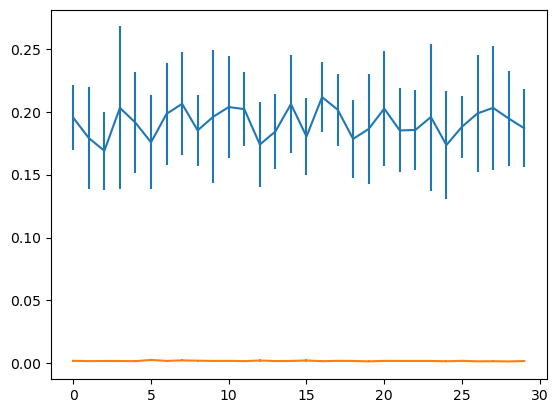

In [9]:
for x, m, s in unpack_solution(solutionx):
    plt.errorbar(x, m, s)

<ErrorbarContainer object of 3 artists>

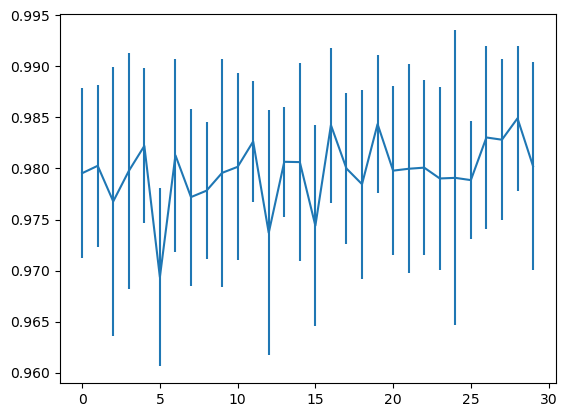

In [10]:
x, m, s = get_inequality(solutionx)
plt.errorbar(x, m, s)

# Make it into a function

In [11]:
def run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun):

    solutionx = []
    for i in range(0, n_rep):

        n_populations = len(groups_population)

        ## VARIABLES OF THE KB
        # The kb will keep track on how many designs are per each population and per each 
        kb_l = [[0]*dimensions for i in range(0, n_populations)]
        kb_l_shared = [0]*dimensions
        kb_s = [[0]*dimensions for i in range(0, n_populations)]
        max_kbs = [[0]*dimensions for i in range(0, n_populations)] # the max design value for each dimension
        dims_each_group = [[0]*delta for i in range(0, n_populations)]


        #
        winning_solution_vec = []

        for initiative in range(0,n_initiatives) :# for each initiative #######################
            max_kbs = [[0]*dimensions for i in range(0, n_populations)] # set this to 0
            kb_s = [[0]*dimensions for i in range(0, n_populations)]

            # Load the short term kb
            for group, li in enumerate(kb_l):

                # Load the knowledge bases
                if SEPARATE_POOLS:
                    kb_s[group] = li.copy()
                else:
                    kb_s[group] = kb_l_shared.copy()

                # Select which dimensions everyone is going to work on
                dims_each_group[group] = random.sample(range(0,dimensions), k=delta)

                for dim in dims_each_group[group]:
                    L = kb_s[group][dim]
                    if L > 0:
                        max_kbs[group][dim] = np.max(random_func(L, L))



            # Simulate the actions during the initiative
            for h in range(0, n_steps):

                # select group of the agent
                group = random.choices(range(0, n_populations), weights=groups_population, k=1)[0]

                # Select a random dimension
                dim = random.choices(dims_each_group[group], k=1)[0]

                # How many solutions have been already generated and what is the maximum
                L = kb_s[group][dim]
                M = max_kbs[group][dim]

                # Generate a new solution
                sol = random_func(1, L)[0]
                kb_s[group][dim] += 1

                if sol > M:
                    max_kbs[group][dim] = sol


            # End of initiative actions
            # Select the winning solutions for each one
            winning_solution = []
            for group in range(0, n_populations):
                sol = 0 

                for dim in dims_each_group[group]:
                    sol += max_kbs[group][dim]
                    err = np.mean(noise_fun(groups_population[group]))
                    sol += err

                winning_solution.append(sol/delta)




            # Load the new designs on the long-term kb
            kb_l_old = kb_l.copy()
            kb_l_shared_old = kb_l_shared.copy()

            for group in range(0, n_populations): # select which KB we are going to use
                if SEPARATE_POOLS:
                    kb_l_t = kb_l[group]
                    kb_l_t_old = kb_l_old[group]
                else:
                    kb_l_t = kb_l_shared
                    kb_l_t_old = kb_l_shared_old

                for dim in dims_each_group[group]: # add the new designs
                    new_designs = kb_s[group][dim]-kb_l_t_old[dim]

                    if WHAT_TO_LOAD=="all":
                        to_add = new_designs
                    elif WHAT_TO_LOAD=="final":
                        to_add = 1
                    elif WHAT_TO_LOAD=="nothing":
                        to_add = 0
                    else:
                        raise Exception("WHAT_TO_LOAD not recognized")

                    kb_l_t[dim] += to_add
                    #print(to_add)

                #print(kb_l_t, to_add)
            #print(kb_s)

            winning_solution_vec.append(winning_solution)
        solutionx.append(winning_solution_vec)
        #print("new")
        
    return solutionx

### Test

In [12]:
n_rep = 10

n_initiatives = 50

# Parameters
groups_population = [1000, 500, 100, 10]
n_steps = 1000
dimensions = 10
delta = 3 # How many dimensions are take into account


# Functions
random_func = lambda n, MAX : 0.001*np.clip((1/np.random.rand(n)), a_min=-100, a_max=MAX) # 1/x with lower variance
ineq_funct = lambda v : (v[0]-v[1])/(v[0]+v[1])

# Additional boolean parameters
SEPARATE_POOLS = True # If True each group will have their own pool
WHAT_TO_LOAD = "all" # "all" "final", "nothing"

# Noise parameters
noise_val = 0.
noise_fun = lambda n : (np.random.rand(n)-0.5)*2*noise_val


solutions = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)


# Test the models in the paper

Parameters

In [13]:
n_rep = 10 # you can bring it down to 10 to speed up the process

n_initiatives = 50

# Parameters
groups_population = [990, 10]
n_steps = 1000
dimensions = 10
delta = 3 # How many dimensions are take into account


# Functions
random_func = lambda n, MAX : 0.001*np.clip((1/np.random.rand(n)), a_min=-100, a_max=MAX) # 1/x with lower variance
ineq_funct = lambda v : (v[0]-v[1])/(v[0]+v[1])

# Noise parameters
noise_val = 0.
noise_fun = lambda n : (np.random.rand(n)-0.5)*2*noise_val

In [14]:
cc = ["navy", "red", "green", "pink"]

# M1

In [15]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = True # If True each group will have their own pool
WHAT_TO_LOAD = "nothing" # "all" "final", "nothing"

solutions_m1 = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)

Text(0, 0.5, 'Average utility')

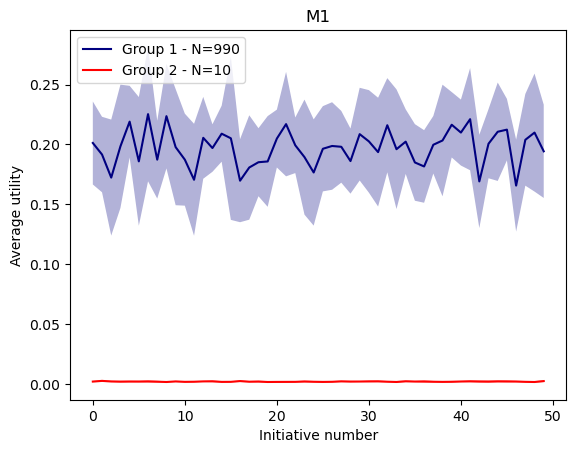

In [16]:
for i, el in enumerate(unpack_solution(solutions_m1)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
plt.legend(loc='upper left')
plt.title("M1")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

# M2

In [17]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = True # If True each group will have their own pool
WHAT_TO_LOAD = "all" # "all" "final", "nothing"

solutions_m2 = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)

Text(0, 0.5, 'Average utility')

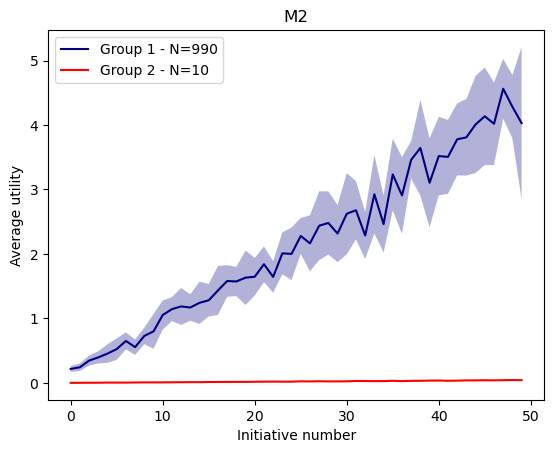

In [18]:
for i, el in enumerate(unpack_solution(solutions_m2)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
plt.legend(loc='upper left')
plt.title("M2")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

# M3

In [19]:
n_initiatives = 500

In [20]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = False # If True each group will have their own pool
WHAT_TO_LOAD = "final" # "all" "final", "nothing"

solutions_m3 = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)

Text(0, 0.5, 'Average utility')

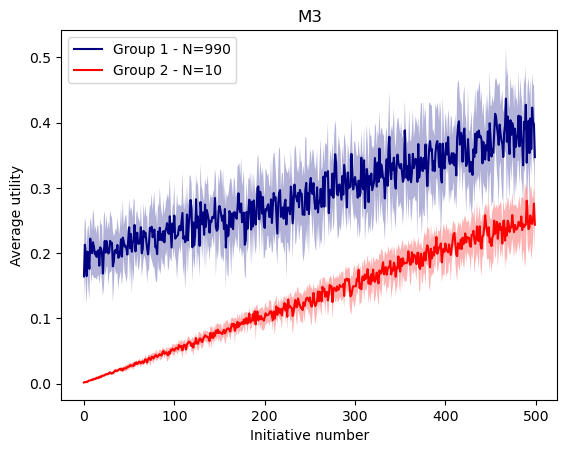

In [21]:
for i, el in enumerate(unpack_solution(solutions_m3)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
plt.legend(loc='upper left')
plt.title("M3")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

# M4

In [22]:
n_initiatives = 50

In [23]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = False # If True each group will have their own pool
WHAT_TO_LOAD = "all" # "all" "final", "nothing"

solutions_m4 = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)

Text(0, 0.5, 'Average utility')

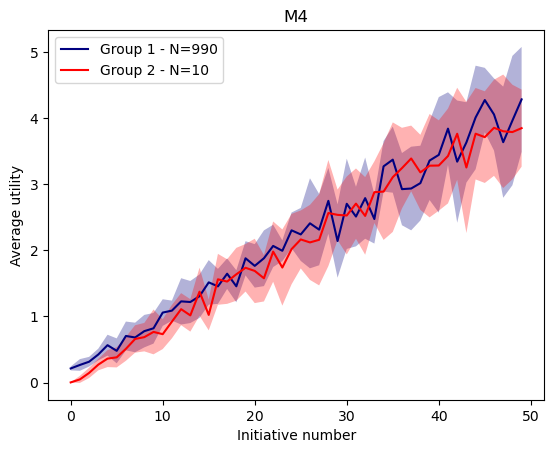

In [24]:
for i, el in enumerate(unpack_solution(solutions_m4)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
plt.legend(loc='upper left')
plt.title("M4")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

### Inequality

Text(0, 0.5, 'Inequality')

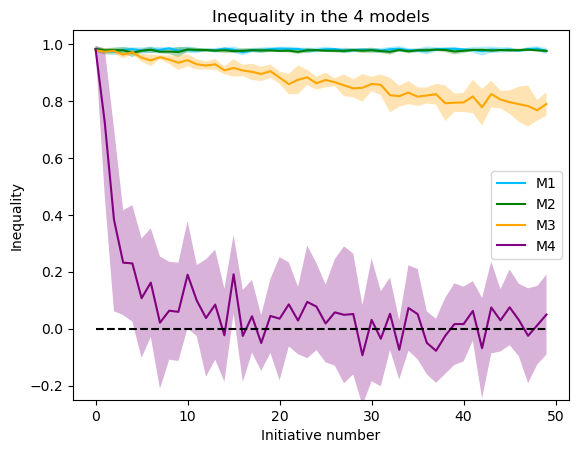

In [25]:
cc = ["deepskyblue", "green", "orange", "purple"]

x, m, s = get_inequality(solutions_m1)
plt.plot(x,m, color=cc[0], label="M1")
plt.fill_between(x,m+s, m-s, color=cc[0], alpha=0.3, edgecolor='none')

x, m, s = get_inequality(solutions_m2)
plt.plot(x,m, color=cc[1], label="M2")
plt.fill_between(x,m+s, m-s, color=cc[1], alpha=0.3, edgecolor='none')

xx, mm, ss = get_inequality(solutions_m3)
m=mm[x]
s=ss[x]
plt.plot(x, m, color=cc[2], label="M3")
plt.fill_between(x,m+s, m-s, color=cc[2], alpha=0.3, edgecolor='none')

x, m, s = get_inequality(solutions_m4)
plt.plot(x,m, color=cc[3], label="M4")
plt.fill_between(x,m+s, m-s, color=cc[3], alpha=0.3, edgecolor='none')

plt.plot(x, x*0, '--k')

plt.legend()

plt.ylim([-0.25, 1.05])
plt.title("Inequality in the 4 models")
plt.xlabel("Initiative number")
plt.ylabel("Inequality")

Text(0, 0.5, 'Inequality')

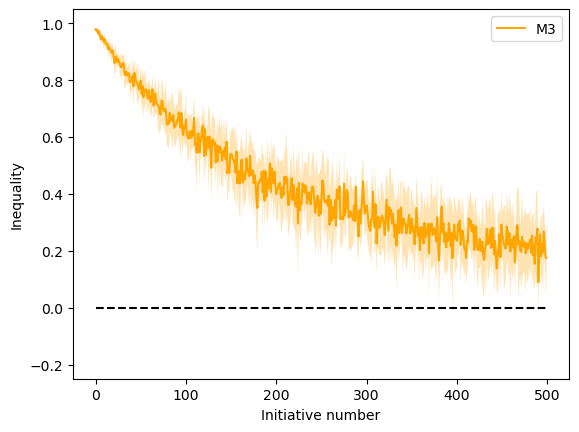

In [26]:
plt.plot(xx, mm, color=cc[2], label="M3")
plt.fill_between(xx,mm+ss, mm-ss, color=cc[2], alpha=0.3, edgecolor='none')
plt.plot(xx, xx*0, '--k')

plt.legend()

plt.ylim([-0.25, 1.05])
plt.xlabel("Initiative number")
plt.ylabel("Inequality")

# Re-test with 60/40

# M2

In [27]:
groups_population = [600, 400]

In [28]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = True # If True each group will have their own pool
WHAT_TO_LOAD = "all" # "all" "final", "nothing"

solutions_m2a = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)

KeyboardInterrupt: 

In [ ]:
for i, el in enumerate(unpack_solution(solutions_m2a)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
plt.legend(loc='upper left')
plt.title("M2")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

# M4

In [ ]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = False # If True each group will have their own pool
WHAT_TO_LOAD = "all" # "all" "final", "nothing"

solutions_m4a = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)

In [ ]:
for i, el in enumerate(unpack_solution(solutions_m4a)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
plt.legend(loc='upper left')
plt.title("M4")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

### Compare inequality in different scenarios

Together

In [ ]:
cc = ["green", "lightgreen", "fuchsia", "purple"]

for i, el in enumerate(unpack_solution(solutions_m2a)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="M2 - Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
for i, el in enumerate(unpack_solution(solutions_m4a)):
    x, m, s = el
    plt.plot(x,m, color=cc[i+2], label="M4 - Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i+2], alpha=0.2, edgecolor='none')
    
plt.legend(loc='upper left')
plt.title("Comparison of M2 and M4")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

# Noise and multiple groups

In [ ]:
cc = ["navy", "red", "green", "pink"]

In [ ]:
#n_rep = 10

#n_initiatives = 50

# Parameters
groups_population = [990, 10]
#n_steps = 1000
#dimensions = 10
#delta = 3 # How many dimensions are take into account


# Functions
#random_func = lambda n, MAX : 0.001*np.clip((1/np.random.rand(n)), a_min=-100, a_max=MAX) # 1/x with lower variance
#ineq_funct = lambda v : (v[0]-v[1])/(v[0]+v[1])

# Noise parameters
noise_val = 1.
noise_fun = lambda n : (np.random.rand(n)-0.5)*2*noise_val

In [ ]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = False # If True each group will have their own pool
WHAT_TO_LOAD = "all" # "all" "final", "nothing"

solutions_m4_noise = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)

In [ ]:
for i, el in enumerate(unpack_solution(solutions_m4_noise)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
plt.legend(loc='upper left')
plt.title("M4")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

# 4 groups and noise

In [ ]:
# Parameters
groups_population = [500, 400, 90, 10]

noise_val = 1.

In [ ]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = False # If True each group will have their own pool
WHAT_TO_LOAD = "all" # "all" "final", "nothing"

solutions_m4_noise_groups = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)

In [ ]:
for i, el in enumerate(unpack_solution(solutions_m4_noise_groups)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
plt.legend(loc='upper left')
plt.title("M4")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

# Group 1 alone

In [ ]:
groups_population = [500]

In [ ]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = False # If True each group will have their own pool
WHAT_TO_LOAD = "all" # "all" "final", "nothing"

solutions_m4_noise_groups_g1 = run_initiatives(n_rep, n_initiatives, groups_population, int(n_steps/2), dimensions, delta, random_func, ineq_funct, noise_val, noise_fun)

In [ ]:
color_last = "black"
groups_population = [500, 400, 90, 10]

for i, el in enumerate(unpack_solution(solutions_m4_noise_groups)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')
    
x, m, s = unpack_solution(solutions_m4_noise_groups_g1)[0]
plt.plot(x,m, color=color_last, label="Group 1 alone - N="+str(groups_population[0]))
plt.fill_between(x,m+s, m-s, color=color_last, alpha=0.3, edgecolor='none')

plt.legend(loc='upper left')
plt.title("M4")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")

# Save for later use

In [44]:
SAVE = False

In [47]:
if SAVE:
    save_var = solutions_m1, solutions_m2, solutions_m3, solutions_m4, solutions_m2a, solutions_m4a, solutions_m1, solutions_m4_noise, solutions_m4_noise_groups, solutions_m4_noise_groups_g1


    with open("AllData_v2.txt", "wb") as fp:   #Pickling
        pickle.dump(save_var, fp)

# Test with exponential growth

In [30]:
# Parameters
groups_population = [500, 400, 90, 10]

noise_val = 1.

In [51]:
random_func2 = lambda n, MAX: np.random.normal(0, 0.1*(2)**(MAX/10**3), n)  

In [52]:
np.random.seed(seed=1)

# Additional boolean parameters
SEPARATE_POOLS = False # If True each group will have their own pool
WHAT_TO_LOAD = "all" # "all" "final", "nothing"

solutions_m4_noise_groups = run_initiatives(n_rep, n_initiatives, groups_population, n_steps, dimensions, delta, random_func2, ineq_funct, noise_val, noise_fun)

Text(0, 0.5, 'Average utility')

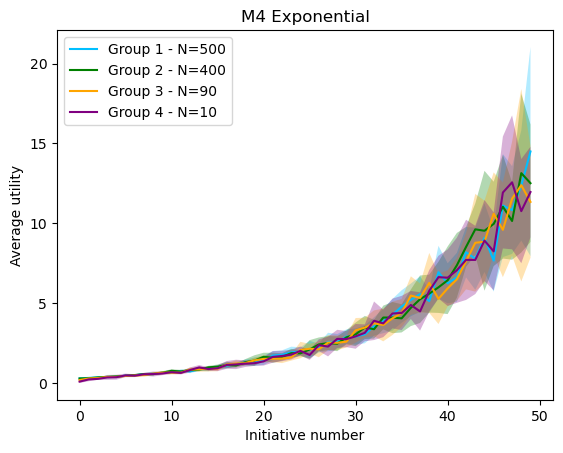

In [53]:
color_last = "black"
groups_population = [500, 400, 90, 10]

for i, el in enumerate(unpack_solution(solutions_m4_noise_groups)):
    x, m, s = el
    plt.plot(x,m, color=cc[i], label="Group "+str(i+1)+" - N="+str(groups_population[i]))
    plt.fill_between(x,m+s, m-s, color=cc[i], alpha=0.3, edgecolor='none')

plt.legend(loc='upper left')
plt.title("M4 Exponential")
plt.xlabel("Initiative number")
plt.ylabel("Average utility")
# plt.semilogy()